In [1]:
import sys
import json
import csv
import yaml

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv

import time
from datetime import datetime

import pprint

import psycopg2
from sqlalchemy import create_engine, text as sql_text

In [2]:
# Create an utilities file util.py in a folder benchmarking and import it
sys.path.append('benchmarking/')
import util
util.hello_world()

Hello World!


In [5]:
import importlib
importlib.reload(util)

<module 'util' from 'c:\\Users\\Karissa\\Downloads\\ecs116_a2-main\\benchmarking\\util.py'>

Graph 1

In [3]:
# Using the json files from PA 2 ---- listings_join_reviews (You can find this in the Files section under PROG-ASSGMT-2)

# Load JSON data from a file
with open('perf_data/listings_join_reviews.json', 'r') as file:
    data_listings = json.load(file)

# Printing the loaded file
print(json.dumps(data_listings, indent=4, sort_keys=True))

{
    "listings_join_reviews_2009": {
        "__": {
            "avg": 0.3972,
            "count": 50,
            "max": 0.532,
            "min": 0.3497,
            "std": 0.0384,
            "timestamp": "2024-05-16-00:02:22"
        },
        "__datetime_in_reviews__": {
            "avg": 0.014,
            "count": 50,
            "max": 0.0335,
            "min": 0.0,
            "std": 0.0077,
            "timestamp": "2024-05-16-00:02:25"
        },
        "__datetime_in_reviews__id_in_listings__": {
            "avg": 0.016,
            "count": 50,
            "max": 0.0281,
            "min": 0.0117,
            "std": 0.0041,
            "timestamp": "2024-05-16-00:02:46"
        },
        "__id_in_listings__": {
            "avg": 0.3667,
            "count": 50,
            "max": 0.4264,
            "min": 0.3311,
            "std": 0.022,
            "timestamp": "2024-05-16-00:02:43"
        }
    },
    "listings_join_reviews_2010": {
        "__": {
         

In [10]:
# Renaming the keys
data_listings_renamed = util.rename_keys(data_listings)

pprint.pp(data_listings_renamed)

{'2009': {'__': {'avg': 0.3972,
                 'min': 0.3497,
                 'max': 0.532,
                 'std': 0.0384,
                 'count': 50,
                 'timestamp': '2024-05-16-00:02:22'},
          '__datetime_in_reviews__': {'avg': 0.014,
                                      'min': 0.0,
                                      'max': 0.0335,
                                      'std': 0.0077,
                                      'count': 50,
                                      'timestamp': '2024-05-16-00:02:25'},
          '__id_in_listings__': {'avg': 0.3667,
                                 'min': 0.3311,
                                 'max': 0.4264,
                                 'std': 0.022,
                                 'count': 50,
                                 'timestamp': '2024-05-16-00:02:43'},
          '__datetime_in_reviews__id_in_listings__': {'avg': 0.016,
                                                      'min': 0.0117,
           

In [11]:
# Extract the avg values for each key inside each year object
def extract_avg_values(data):
    avg_values = {}
    for year, details in data.items():
        avg_values[year] = {}
        for key, metrics in details.items():
            if 'avg' in metrics:
                avg_values[year][key] = metrics['avg']
    return avg_values

# Extract the avg values
avg_values = extract_avg_values(data_listings_renamed)

# pprint.pp(avg_values)

# Map the keys to the custom labels
key_labels = {
    "__": "no_index",
    "__datetime_in_reviews__": "datetime_index",
    "__id_in_listings__": "id_index",
    "__datetime_in_reviews__id_in_listings__": "datetime_and_id_index"
}

# Prepare data for DataFrame
data_for_df = {label: [] for label in key_labels.values()}
data_for_df['Year'] = sorted(avg_values.keys())

for year in data_for_df['Year']:
    for key, label in key_labels.items():
        data_for_df[label].append(avg_values[year].get(key, None))

# Create DataFrame
df = pd.DataFrame(data_for_df)

# Set 'Year' as the index
df.set_index('Year', inplace=True)

# Display the DataFrame
print(df)

      no_index  datetime_index  id_index  datetime_and_id_index
Year                                                           
2009    0.3972          0.0140    0.3667                 0.0160
2010    0.3702          0.0166    0.3527                 0.0147
2011    0.3824          0.0243    0.3536                 0.0217
2012    0.4154          0.0335    0.3582                 0.0400
2013    0.3588          0.0593    0.4080                 0.0610
2014    0.4454          0.1240    0.3996                 0.1290
2015    0.4306          0.2687    0.4243                 0.2540
2016    0.4392          0.1629    0.4466                 0.1457
2017    0.4685          0.1763    0.4458                 0.1814
2018    0.6066          0.2429    0.6154                 0.2601
2019    1.8606          1.7713    1.8083                 1.8222
2020    0.4366          0.2013    0.4363                 0.1877
2021    1.7712          0.4546    1.8480                 0.4050
2022    0.6040          0.6236    0.6079

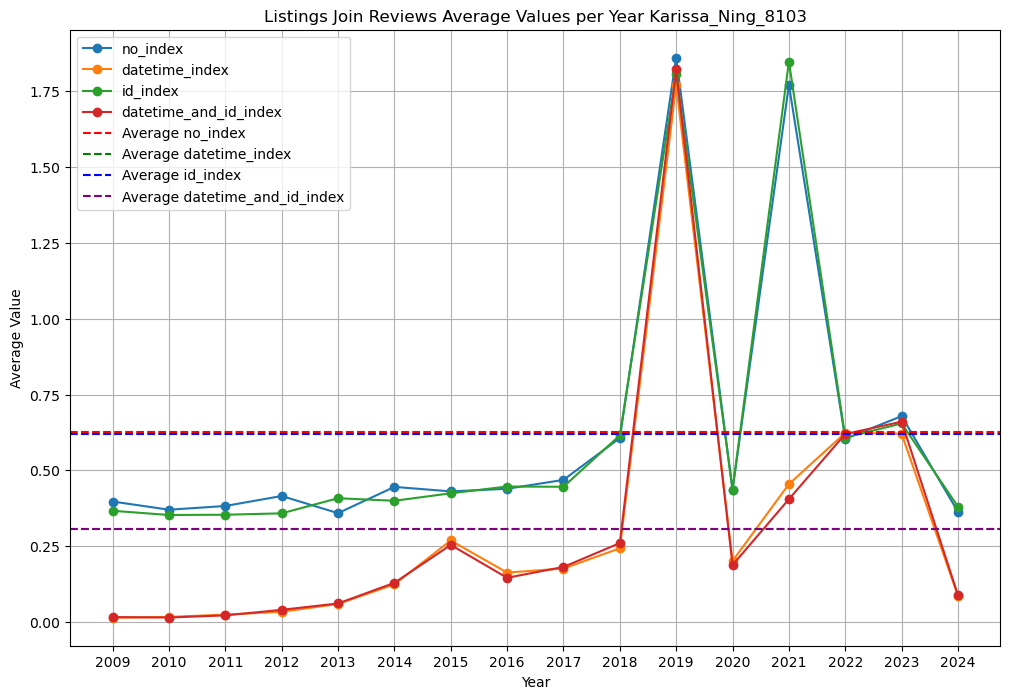

In [12]:
# Plotting the data
plt.figure(figsize=(12, 8))

# Plot each category data
for label in key_labels.values():
    plt.plot(df.index, df[label], marker='o', label=label)
    
colors = ['red', 'green', 'blue', 'purple']

# Calculate and plot average lines for each index across all years
for idx, label in enumerate(key_labels.values()):
    avg_value = df[label].mean()
    plt.axhline(y=avg_value, linestyle='--', color=colors[idx], label=f'Average {label}')

plt.title('Listings Join Reviews Average Values per Year Karissa_Ning_8103')
plt.xlabel('Year')
plt.ylabel('Average Value')
plt.legend()
plt.grid(True)
plt.show()

Graph 2

In [14]:
# Extract the std values for each key inside each year object
def extract_std_values(data):
    std_values = {}
    for year, details in data.items():
        std_values[year] = {}
        for key, metrics in details.items():
            if 'std' in metrics:
                std_values[year][key] = metrics['std']
    return std_values

# Extract the std values
std_values = extract_std_values(data_listings_renamed)

# pprint.pp(std_values)

# Map the keys to the custom labels
# key_labels = {
#     "__": "no_index",
#     "__datetime_in_reviews__": "datetime_index",
#     "__id_in_listings__": "id_index",
#     "__datetime_in_reviews__id_in_listings__": "datetime_and_id_index"
# }

# Prepare data for DataFrame
data_for_df = {label: [] for label in key_labels.values()}
data_for_df['Year'] = sorted(std_values.keys())

for year in data_for_df['Year']:
    for key, label in key_labels.items():
        data_for_df[label].append(std_values[year].get(key, None))

# Create DataFrame
df = pd.DataFrame(data_for_df)

# Set 'Year' as the index
df.set_index('Year', inplace=True)

# Display the DataFrame
print(df)

      no_index  datetime_index  id_index  datetime_and_id_index
Year                                                           
2009    0.0384          0.0077    0.0220                 0.0041
2010    0.0281          0.0095    0.0094                 0.0068
2011    0.0594          0.0155    0.0110                 0.0092
2012    0.0900          0.0108    0.0305                 0.0306
2013    0.0142          0.0418    0.0364                 0.0284
2014    0.0850          0.0321    0.0196                 0.0500
2015    0.0287          0.0686    0.0339                 0.0367
2016    0.0216          0.0973    0.0308                 0.0259
2017    0.0517          0.0313    0.0387                 0.0600
2018    0.0599          0.0379    0.0589                 0.0968
2019    0.1682          0.1980    0.1899                 0.1657
2020    0.0362          0.0831    0.0335                 0.0645
2021    0.1735          0.1514    0.2012                 0.0930
2022    0.0328          0.0720    0.0258

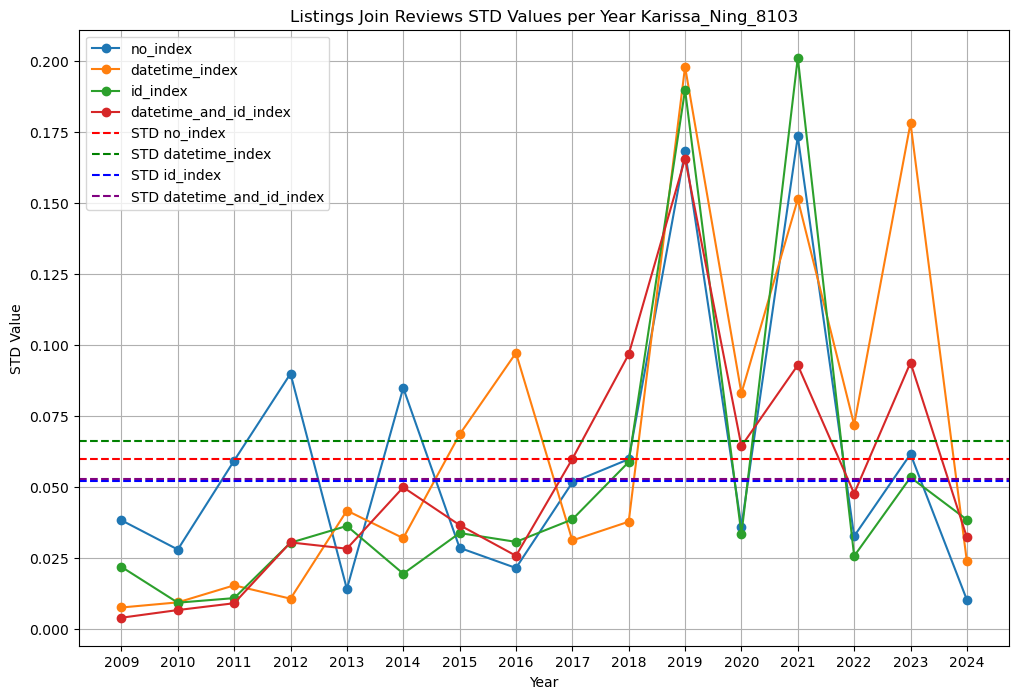

In [15]:
# Plotting the data
plt.figure(figsize=(12, 8))

# Plot each category data
for label in key_labels.values():
    plt.plot(df.index, df[label], marker='o', label=label)
    
colors = ['red', 'green', 'blue', 'purple']

# Calculate and plot std lines for each index across all years
for idx, label in enumerate(key_labels.values()):
    std_value = df[label].mean()
    plt.axhline(y=std_value, linestyle='--', color=colors[idx], label=f'STD {label}')

plt.title('Listings Join Reviews STD Values per Year Karissa_Ning_8103')
plt.xlabel('Year')
plt.ylabel('STD Value')
plt.legend()
plt.grid(True)
plt.show()